# **TP1 - Grupo 4**
Pedro Paulo Costa Pereira - A88062

Tiago André Oliveira Leite - A91693

# <center>TP1 Logica Computacional</center>

# **Problema 2 - Sudoku**
Da definição do jogo “Sudoku” generalizado para a dimensão $N$; o problema tradicional corresponde ao caso $N=3$. O objetivo do Sudoku é preencher uma grelha de $\,N^2\times N^2\,$ com inteiros positivos no intervalo $\,1$ até $\,N^2\,$, satisfazendo as seguintes regras:<br><br>
        - Cada inteiro no intervalo $\,1$ até $\,N^2\,$ocorre  só uma vez em cada coluna, linha e secção $\,N\times N\,$.<br><br>
        - No início do jogo uma fração $\,0\leq 𝛼< 1\,$ das $\,N^4\,$ casas da grelha são preenchidas de forma consistente com a regra anterior. 

## Implementação

Para a resolução deste problema, utilizaremos um solver disponivel na biblioteca de programação linear do OR-Tools, o *pywraplp*. Portanto, começaremos por instalar o OR-Tools.

In [1]:
!pip install ortools

In [4]:
import math
import random
import timeit
import time
from ortools.linear_solver import pywraplp
import matplotlib.pyplot as plt

### Variaveis do Problema
Para resolver o problema foram utilizadas $\,N^2\times N^2\times N^2\,$ variavies binarias, que nos premite verificar qual o número que vai ser colocado numa determinada linha e coluna da grelja do sudoku.<br>
Assim sendo foi definido o seguinte grupo de variavies:<br>
- $\quad cube_{row,col,depth}$ - variavel que represena o número $depth + 1$ na linha $row$ e na coluna $col$.


### Restrições
- $\forall_{row,col,row}$  $cube[(row,col,depth)] \in \{0,1\}$<br>
- $\forall_{row,col}\sum_{depth}$ $cube[(row,col,depth)] == 1$<br>
- $\forall_{row,depth}\sum_{col}$ $cube[(row,col,depth)] == 1$<br>
- $\forall_{depth,col}\sum_{row}$ $cube[(row,col,depth)] == 1$

Seja $n$ uma secção  $\,N\times N\,$ do cubo: <br>
- $\forall_{n_{row},n_{col}}\sum_{depth}$ $cube[(n_{row},n_{col},depth)] == 1$<br>
- $\forall_{n_{row},depth}\sum_{n_{row}}$ $cube[(n_{row},n_{col},depth)] == 1$<br>
- $\forall_{depth,n_{col}}\sum_{n_{row}}$ $cube[(n_{row},n_{col},depth)] == 1$



### Função que imprime a grelha do sudoku

In [5]:
def print_sudoku(sudoku):
    grid = 0 
    l = len(sudoku)
    n = int(math.sqrt(l))
    pad = 1 + l // 10
    r = (l + n) * (pad + 1)  +1
    if n > 4 and not grid:
        for i in range(l):
            for j in range(l):
                print(f'{sudoku[i][j]}'.ljust(pad), end = " ")
            print('')
        return 
                
    for i in range(l):
        if i % n == 0:
            print("-"*r)
        for j in range(l):
            if  j % n == 0:
                print("|".ljust(pad), end = " ")
            print(f'{sudoku[i][j]}'.ljust(pad), end = " ")
            if  j == l-1:
                print("|".ljust(pad), end = " ")
        print('')
    print("-" * r)

### Função auxiliar que converte o resultado do solver numa matriz

In [6]:
def converter(cube,dim):
    mat = [[0 for a in range(dim)] for b in range(dim) ]
    for row in range(dim):
        for col in range(dim):
            for depth in range(dim):
                if cube[(row,col,depth)].solution_value() == 1:
                    mat[row][col] = depth + 1
    return mat

### Função que inicializa a grelha do sudoku
Recebe como parametros a dimensão $N$ e a fracção $0 ≤ α < 1$ de casas que sao preenchidas. Para tal coloca $N$ números aletorios e depois tenta resolver o sudoku. De seguida apaga o número de números necessários para satisfazer α

In [23]:
def sudoku_generator(N, alpha):
    dim = N*N
    delete = int(dim * dim * (1-alpha))
    num_squares = int(math.sqrt(dim))
    solver = pywraplp.Solver.CreateSolver('SCIP')
    cube = {}
    
    if alpha == 0:
        mat = [[0 for c in range(dim)] for r in range(dim)]
        return mat
    
    
    for row in range(dim):
        for col in range(dim):
            for depth in range(dim):
                cube[(row,col,depth)] = solver.BoolVar('%i%i%i' % (row,col,depth))
    
    for row in range(dim):
        for col in range(dim):
            val = []
            for depth in range(dim):
                val.append(cube[(row,col,depth)])
            solver.Add(sum(val) == 1)
    
    for row in range(dim):
        for depth in range(dim):
            val = []
            for col in range(dim):
                val.append(cube[(row,col,depth)])
            solver.Add(sum(val) == 1)
    
    for depth in range(dim):
        for col in range(dim):
            val = []
            for row in range(dim):
                val.append(cube[(row, col, depth)])
            solver.Add(sum(val) == 1)

    
    
    for depth in range(dim):
        for row in range(0, dim, N):
            for col in range (0, dim, N):
                val = []
                for i in range(N):
                    for j in range(N):
                        val.append(cube[(row + i , col + j , depth)] )
                solver.Add(sum(val) == 1)
    
    # gerar alguma aleatoriedade
    for i in range(N):
        randoms = []
        row = random.randint(0,dim-1)
        col = random.randint(0,dim-1)
        depth = i
        while (row,col) in randoms:
            row = random.randint(0,dim-1)
            col = random.randint(0,dim-1)
        randoms.append((row,col))
        solver.Add(cube[(row,col,depth)] == 1)
    
    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        mat = converter(cube, dim)
        
        # apagar celuas da matriz de forma a ficarem apenas alpha preenchidas
        candidates = [(a,b) for a in range(dim) for b in range(dim)]
        len_candidates = len(candidates)
        for d in range(delete):
            selected = random.randint(0,len_candidates-1)
            (row, col) = candidates.pop(selected)
            len_candidates -= 1
            mat[row][col] = 0
        
        return mat
    else:
        return False

#### Exemplo

In [65]:
mat = sudoku_generator(3, 0.2)
print_sudoku(mat)

-------------------------
| 0 9 0 | 6 7 5 | 0 0 2 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 4 1 | 0 6 0 | 
-------------------------
| 0 6 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 1 0 | 0 0 0 | 
| 0 2 0 | 4 0 0 | 0 0 0 | 
-------------------------
| 0 0 0 | 0 8 0 | 1 0 0 | 
| 3 8 0 | 0 5 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
-------------------------


### Outra forma mais simples de inicializar o sudoku mas que produz sudokus impossiveis

In [66]:
def check(sudoku, row, column, number):
    if number in sudoku[row]:
        return False
    for r in sudoku:
        if r[column] == number:
            return False
    n = int(math.sqrt(len(sudoku)))
    r = (row // n) * n
    c = (column // n) * n
    for i in range(n):
        for j in range(n):
            if sudoku[r+i][c+j] == number:
                return False
    return True

def sudoku_generator_simple(N, alpha):
    dim = N*N
    filled = int(dim * dim * alpha)
    mat = [[0 for a in range(dim)] for a in range(dim)]
    while(filled > 0):
        row = random.randint(0,dim-1)
        col = random.randint(0,dim-1)
        number = random.randint(1, dim - 1)
        while(mat[row][col] != 0 or not check(mat,row,col,number)):
            row = random.randint(0, dim-1)
            col = random.randint(0, dim-1)
            number = random.randint(1,dim-1)
        mat[row][col] = number
        filled -=1

    return mat

#### Exemplo

In [67]:
mat = sudoku_generator_simple(3,0.2)
if mat:
    print_sudoku(mat)

-------------------------
| 0 0 0 | 0 0 4 | 0 5 2 | 
| 0 0 6 | 0 0 0 | 0 0 0 | 
| 7 2 0 | 0 0 0 | 0 0 0 | 
-------------------------
| 1 0 0 | 0 0 0 | 0 3 0 | 
| 0 0 0 | 0 2 3 | 0 0 0 | 
| 0 0 0 | 4 0 1 | 0 0 8 | 
-------------------------
| 0 0 0 | 0 8 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 3 0 0 | 0 6 0 | 
-------------------------


### Função que resolve o sudoku

In [8]:
def sudoku_solver(sudoku):
    solver = pywraplp.Solver.CreateSolver('SCIP')
    dim = len(sudoku)
    N = int(math.sqrt(dim))
    cube = {}

    for row in range(dim):
        for col in range(dim):
            for depth in range(dim):
                cube[(row,col,depth)] = solver.BoolVar('%i%i%i' % (row,col,depth))


    for row in range(dim):
        for col in range(dim):
            val = []
            for depth in range(dim):
                val.append(cube[(row,col,depth)])
            solver.Add(sum(val) == 1)

    for row in range(dim):
        for depth in range(dim):
            val = []
            for col in range(dim):
                val.append(cube[(row,col,depth)])
            solver.Add(sum(val) == 1)

    for depth in range(dim):
        for col in range(dim):
            val = []
            for row in range(dim):
                val.append(cube[(row, col, depth)])
            solver.Add(sum(val) == 1)

    for depth in range(dim):
        for row in range(0, dim, N):
            for col in range (0, dim, N):
                val = []
                for i in range(N):
                    for j in range(N):
                        val.append(cube[(row + i , col + j , depth)] )
                solver.Add(sum(val) == 1)

    for i in range(dim):
        for j in range(dim):
            if sudoku[i][j] != 0:
                solver.Add(cube[(i,j,sudoku[i][j]-1)] == 1)


    status = solver.Solve()
    mat = converter(cube, dim)
    if status == pywraplp.Solver.OPTIMAL:
        return mat
    else:
        return False

### Testes

In [9]:
def test_sudoku(N, alpha):
    mat = sudoku_generator(N, alpha)
    print("Sudoku")
    print_sudoku(mat)
    print("")
    mat = sudoku_solver(mat)
    if mat:
        print("Solução")
        print_sudoku(mat)
        print("")
    

In [2]:
N = [3,4,5]
times = [[None for n in N] for n in range(4)]

### $\alpha = 0.0$

#### $N = 3$

In [72]:
times[0][0] = timeit.timeit(stmt='test_sudoku(3,0.0)', setup='from __main__ import test_sudoku',number=1 )
print("Tempo de execução em segundos:",times[0][0])

Sudoku
-------------------------
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
-------------------------
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
-------------------------
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
-------------------------

Solução
-------------------------
| 1 2 3 | 4 5 6 | 8 7 9 | 
| 8 9 7 | 1 2 3 | 4 5 6 | 
| 6 4 5 | 7 8 9 | 1 2 3 | 
-------------------------
| 7 1 2 | 3 4 5 | 6 9 8 | 
| 9 5 6 | 2 1 8 | 3 4 7 | 
| 4 3 8 | 6 9 7 | 2 1 5 | 
-------------------------
| 5 8 1 | 9 3 2 | 7 6 4 | 
| 3 7 4 | 5 6 1 | 9 8 2 | 
| 2 6 9 | 8 7 4 | 5 3 1 | 
-------------------------

Tempo de execução em segundos: 0.04929005700068956


#### $N = 4$

In [73]:
times[0][1] = timeit.timeit(stmt='test_sudoku(4,0.0)', setup='from __main__ import test_sudoku',number=1)
print("Tempo de execução em segundos:",times[0][1])

Sudoku
-------------------------------------------------------------
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
-------------------------------------------------------------
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
-------------------------------------------------------------
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
---------------------------------------

#### $N = 5$

In [79]:
times[0][2] = timeit.timeit(stmt='test_sudoku(5,0.0)', setup='from __main__ import test_sudoku',number=1)
print("Tempo de execução em segundos:",times[0][2])

Sudoku
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

#### Gráfico Tempo de Execução / N 

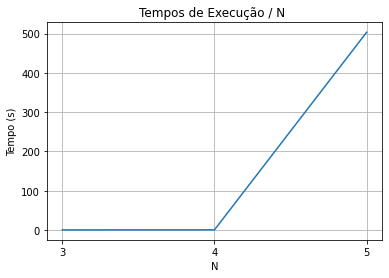

In [80]:
plt.plot(N, times[0])
plt.xticks(N)
plt.title("Tempos de Execução / N ")
plt.ylabel("Tempo (s)")
plt.xlabel("N")
plt.grid(True)

### $\alpha = 0.2$

#### $N = 3$

In [74]:
times[1][0] = timeit.timeit(stmt='test_sudoku(3,0.2)', setup='from __main__ import test_sudoku',number=1 )
print("Tempo de execução em segundos:",times[1][0])

Sudoku
-------------------------
| 0 0 0 | 0 0 1 | 0 0 0 | 
| 2 0 0 | 0 0 0 | 0 0 0 | 
| 1 4 0 | 0 0 0 | 0 0 0 | 
-------------------------
| 0 0 0 | 0 4 0 | 0 0 2 | 
| 0 2 0 | 0 3 5 | 0 0 0 | 
| 7 0 0 | 0 0 2 | 0 5 0 | 
-------------------------
| 0 0 2 | 0 5 0 | 7 0 0 | 
| 0 0 0 | 0 0 3 | 0 0 0 | 
| 0 0 8 | 0 0 0 | 0 0 0 | 
-------------------------

Solução
-------------------------
| 8 7 9 | 4 2 1 | 5 6 3 | 
| 2 5 6 | 3 9 7 | 4 1 8 | 
| 1 4 3 | 5 8 6 | 9 2 7 | 
-------------------------
| 9 3 5 | 1 4 8 | 6 7 2 | 
| 6 2 1 | 7 3 5 | 8 4 9 | 
| 7 8 4 | 9 6 2 | 3 5 1 | 
-------------------------
| 4 1 2 | 8 5 9 | 7 3 6 | 
| 5 9 7 | 6 1 3 | 2 8 4 | 
| 3 6 8 | 2 7 4 | 1 9 5 | 
-------------------------

Tempo de execução em segundos: 0.09160416499980784


#### $N = 4$

In [75]:
times[1][1] = timeit.timeit(stmt='test_sudoku(4,0.2)', setup='from __main__ import test_sudoku',number=1)
print("Tempo de execução em segundos:",times[1][1])

Sudoku
-------------------------------------------------------------
|  0  0  0  0  |  0  0  0  8  |  0  0  0  11 |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  15 |  9  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  10 0  0  |  0  0  0  8  |  0  2  3  0  |  
-------------------------------------------------------------
|  2  1  0  0  |  0  5  0  7  |  0  0  11 0  |  0  0  0  0  |  
|  0  0  8  0  |  0  1  0  0  |  0  0  0  0  |  0  0  12 0  |  
|  0  9  0  0  |  0  0  0  0  |  0  0  4  0  |  6  0  0  7  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  8  0  |  0  0  4  0  |  
-------------------------------------------------------------
|  0  0  0  0  |  0  0  0  0  |  11 0  0  0  |  0  16 15 10 |  
|  7  0  0  6  |  0  4  0  5  |  10 0  16 0  |  11 0  0  13 |  
|  0  12 0  0  |  0  0  0  0  |  0  4  0  0  |  7  0  5  0  |  
|  0  16 0  0  |  0  12 0  0  |  0  0  0  0  |  0  0  0  0  |  
---------------------------------------

#### $N = 5$

In [76]:
times[1][2] = timeit.timeit(stmt='test_sudoku(5,0.2)', setup='from __main__ import test_sudoku',number=1)
print("Tempo de execução em segundos:",times[1][2])

Sudoku
0   0   0   0   0   14  0   0   19  0   0   0   10  0   0   11  2   0   0   0   8   23  0   1   0   
0   0   1   0   0   0   0   0   0   15  0   9   18  0   14  0   7   0   0   0   0   19  0   0   16  
0   0   0   14  0   0   0   0   0   0   0   21  5   16  0   9   18  0   0   0   0   0   0   0   0   
2   16  0   12  0   0   0   0   0   20  24  0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   11  0   0   0   0   0   0   0   0   0   0   0   0   0   10  0   0   24  0   0   0   0   0   
0   0   0   0   7   0   0   0   0   0   0   0   0   0   0   4   9   0   0   0   5   0   0   13  0   
0   0   0   0   0   11  0   0   0   0   0   0   0   0   0   0   5   0   0   0   0   24  0   6   0   
0   0   0   0   24  0   0   0   0   0   0   0   15  0   0   0   16  6   0   2   23  0   0   0   0   
0   0   0   21  0   18  0   12  0   4   0   0   0   0   0   3   0   0   0   0   10  0   0   0   0   
0   0   0   0   0   24  14  15  0   0   18  0   0   0   0   0   0   0   11  0   0   

#### Gráfico Tempo de Execução / N

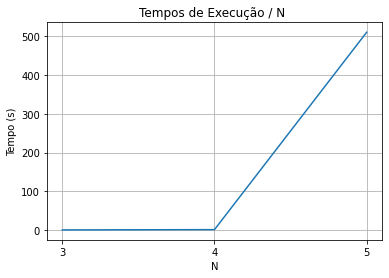

In [77]:
plt.plot(N, times[1])
plt.xticks(N)
plt.title("Tempos de Execução / N ")
plt.ylabel("Tempo (s)")
plt.xlabel("N")
plt.grid(True)

### $\alpha = 0.4$

#### $N = 3$

In [10]:
times[2][0] = timeit.timeit(stmt='test_sudoku(3,0.4)', setup='from __main__ import test_sudoku',number=1 )
print("Tempo de execução em segundos:",times[2][0])

Sudoku
-------------------------
| 1 0 0 | 0 0 2 | 0 0 0 | 
| 7 0 0 | 9 0 6 | 0 0 0 | 
| 0 0 2 | 5 4 0 | 9 8 0 | 
-------------------------
| 3 7 0 | 8 2 5 | 0 0 0 | 
| 0 4 5 | 7 0 0 | 2 0 0 | 
| 8 0 0 | 0 0 4 | 7 3 0 | 
-------------------------
| 5 8 0 | 0 6 0 | 0 0 1 | 
| 0 0 0 | 0 0 0 | 8 2 3 | 
| 2 1 0 | 0 0 0 | 0 0 6 | 
-------------------------

Solução
-------------------------
| 1 9 8 | 3 7 2 | 6 5 4 | 
| 7 5 4 | 9 8 6 | 3 1 2 | 
| 6 3 2 | 5 4 1 | 9 8 7 | 
-------------------------
| 3 7 6 | 8 2 5 | 1 4 9 | 
| 9 4 5 | 7 1 3 | 2 6 8 | 
| 8 2 1 | 6 9 4 | 7 3 5 | 
-------------------------
| 5 8 3 | 2 6 9 | 4 7 1 | 
| 4 6 9 | 1 5 7 | 8 2 3 | 
| 2 1 7 | 4 3 8 | 5 9 6 | 
-------------------------

Tempo de execução em segundos: 0.11473362099968654


#### $N = 4$

In [11]:
times[2][1] = timeit.timeit(stmt='test_sudoku(4,0.4)', setup='from __main__ import test_sudoku',number=1)
print("Tempo de execução em segundos:",times[2][1])

Sudoku
-------------------------------------------------------------
|  0  0  3  4  |  0  6  0  0  |  0  0  0  12 |  0  0  0  16 |  
|  0  0  0  8  |  1  0  0  4  |  13 0  0  0  |  9  0  0  0  |  
|  0  0  0  12 |  0  14 0  16 |  1  2  3  0  |  5  0  7  0  |  
|  13 14 15 0  |  0  10 11 0  |  0  6  0  0  |  0  2  3  4  |  
-------------------------------------------------------------
|  0  0  5  3  |  4  0  6  9  |  8  0  10 0  |  0  0  0  0  |  
|  4  7  0  9  |  0  0  0  0  |  0  0  16 0  |  8  11 10 0  |  
|  0  0  0  0  |  12 0  0  0  |  0  1  4  0  |  0  0  0  0  |  
|  0  0  16 0  |  0  0  0  0  |  0  5  9  0  |  0  0  4  0  |  
-------------------------------------------------------------
|  0  4  0  0  |  0  0  0  7  |  0  0  12 0  |  0  0  13 15 |  
|  6  5  8  0  |  10 4  0  0  |  16 3  14 0  |  11 0  12 2  |  
|  0  0  0  0  |  0  0  14 0  |  0  0  0  6  |  0  1  8  0  |  
|  0  0  13 0  |  0  9  0  0  |  0  8  1  0  |  10 0  5  0  |  
---------------------------------------

#### $N = 5$

In [12]:
times[2][2] = timeit.timeit(stmt='test_sudoku(5,0.4)', setup='from __main__ import test_sudoku',number=1)
print("Tempo de execução em segundos:",times[2][2])

Sudoku
0   23  0   7   0   0   0   24  20  0   0   0   25  0   0   0   0   0   0   4   13  0   0   0   0   
0   8   19  0   0   0   23  5   0   22  0   13  24  0   0   0   0   0   25  0   9   0   0   0   6   
11  0   13  24  0   17  0   18  15  0   23  12  0   0   10  1   0   8   3   7   16  0   0   0   22  
0   12  0   0   20  0   0   11  0   4   1   0   0   17  0   14  0   2   0   0   0   0   0   10  0   
3   16  0   0   0   6   10  12  1   0   0   7   11  0   22  0   17  24  20  0   0   8   5   0   0   
0   20  0   0   4   0   1   0   0   25  11  0   3   0   0   12  23  14  0   9   0   0   19  0   16  
21  0   23  2   0   5   0   4   12  24  0   15  22  20  0   0   0   0   0   6   8   13  14  11  9   
0   0   14  0   7   18  16  0   0   0   0   23  0   0   6   24  0   20  0   0   0   22  0   17  0   
25  0   6   0   9   0   17  23  0   20  13  8   12  0   0   0   22  4   5   21  18  0   0   24  1   
0   24  5   0   0   15  0   0   0   6   17  0   4   0   0   0   19  0   18  0   0   

#### Gráfico Tempo de Execução / N

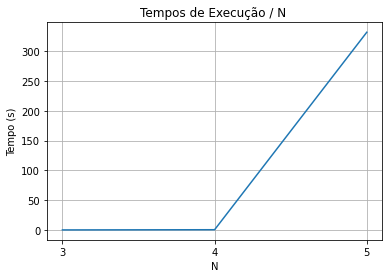

In [20]:
plt.plot(N, times[2])
plt.xticks(N)
plt.title("Tempos de Execução / N ")
plt.ylabel("Tempo (s)")
plt.xlabel("N")
plt.grid(True)

### $\alpha = 0.6$

#### $N = 3$

In [16]:
times[3][0] = timeit.timeit(stmt='test_sudoku(3,0.6)', setup='from __main__ import test_sudoku',number=1 )
print("Tempo de execução em segundos:",times[3][0])

Sudoku
-------------------------
| 0 9 0 | 0 6 5 | 4 0 3 | 
| 0 0 0 | 0 0 0 | 8 0 1 | 
| 6 3 0 | 0 4 1 | 5 9 0 | 
-------------------------
| 9 0 0 | 0 8 0 | 0 5 2 | 
| 8 0 6 | 5 1 9 | 7 3 0 | 
| 5 1 0 | 4 0 7 | 0 8 0 | 
-------------------------
| 0 8 0 | 0 7 6 | 3 1 0 | 
| 3 7 0 | 0 9 8 | 2 4 6 | 
| 2 6 1 | 3 5 4 | 0 7 8 | 
-------------------------

Solução
-------------------------
| 1 9 8 | 7 6 5 | 4 2 3 | 
| 7 5 4 | 9 3 2 | 8 6 1 | 
| 6 3 2 | 8 4 1 | 5 9 7 | 
-------------------------
| 9 4 7 | 6 8 3 | 1 5 2 | 
| 8 2 6 | 5 1 9 | 7 3 4 | 
| 5 1 3 | 4 2 7 | 6 8 9 | 
-------------------------
| 4 8 9 | 2 7 6 | 3 1 5 | 
| 3 7 5 | 1 9 8 | 2 4 6 | 
| 2 6 1 | 3 5 4 | 9 7 8 | 
-------------------------

Tempo de execução em segundos: 0.07458067299921822


#### $N = 4$

In [18]:
times[3][1] = timeit.timeit(stmt='test_sudoku(4,0.6)', setup='from __main__ import test_sudoku',number=1)
print("Tempo de execução em segundos:",times[3][1])

Sudoku
-------------------------------------------------------------
|  11 6  0  15 |  0  1  8  0  |  0  9  0  10 |  4  14 0  13 |  
|  0  0  0  7  |  13 12 11 0  |  4  0  5  2  |  0  6  0  0  |  
|  3  1  2  0  |  4  0  6  7  |  0  13 16 15 |  11 0  5  0  |  
|  8  13 5  4  |  9  0  15 0  |  0  6  7  11 |  2  3  0  10 |  
-------------------------------------------------------------
|  7  0  8  10 |  1  3  14 0  |  16 4  13 12 |  6  0  15 0  |  
|  6  12 0  0  |  0  0  0  15 |  5  0  8  14 |  13 2  0  4  |  
|  0  0  0  0  |  11 0  4  8  |  9  7  0  0  |  12 0  10 0  |  
|  16 4  0  11 |  0  0  13 6  |  2  3  0  0  |  0  0  8  0  |  
-------------------------------------------------------------
|  0  3  0  13 |  8  15 12 14 |  11 16 0  7  |  0  0  1  0  |  
|  0  0  6  0  |  7  11 0  1  |  10 0  4  13 |  3  8  14 2  |  
|  15 8  0  0  |  3  16 10 4  |  0  2  14 5  |  9  0  13 0  |  
|  0  5  7  14 |  6  0  2  9  |  3  12 0  0  |  16 15 4  11 |  
---------------------------------------

#### $N = 5$

In [19]:
times[3][2] = timeit.timeit(stmt='test_sudoku(5,0.6)', setup='from __main__ import test_sudoku',number=1)
print("Tempo de execução em segundos:",times[3][2])

Sudoku
0   2   11  0   12  13  0   0   4   0   0   22  25  23  0   20  0   21  0   17  14  7   1   8   3   
0   8   0   25  24  18  11  0   0   17  3   14  0   21  20  23  0   0   6   1   13  0   0   19  4   
0   0   14  0   17  20  0   0   1   19  0   0   11  0   16  0   0   0   7   12  23  2   18  9   15  
0   9   19  20  1   0   0   0   0   12  7   2   0   0   17  0   3   5   0   4   0   11  24  25  6   
18  15  0   0   3   0   5   0   8   2   0   4   13  0   1   24  0   11  10  0   17  0   12  0   16  
0   18  13  0   0   0   0   12  5   22  2   0   4   6   15  17  23  8   0   21  9   25  16  0   20  
8   0   0   0   4   0   21  19  9   6   23  0   22  7   12  0   20  3   16  0   10  24  0   2   0   
12  0   15  0   20  14  17  0   13  3   21  11  0   8   0   0   0   6   24  0   0   23  7   0   5   
0   0   0   16  0   0   4   2   24  25  0   20  0   3   13  11  15  0   0   19  8   22  0   6   14  
24  0   3   0   7   23  18  11  20  0   5   0   0   10  14  0   0   13  22  0   0   

#### Gráfico Tempo de Execução / N

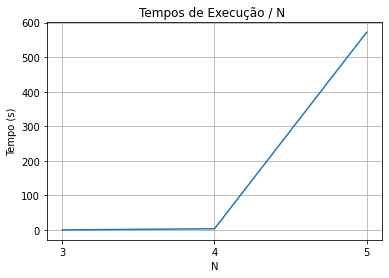

In [21]:
plt.plot(N, times[3])
plt.xticks(N)
plt.title("Tempos de Execução / N ")
plt.ylabel("Tempo (s)")
plt.xlabel("N")
plt.grid(True)

### Nota

Para $N = 5$ a função demora varios minutos a executar, pelo que para $N \geq 5$ ainda vai ser mais lento, o que deve ser provocado pelo ao facto de as soluções terem complexidade exponencial em $N$. Se fizermos uma analise ao número de variaveis em função de $N$ verificamos que:<br>
- Para inicializar o sudoku temos $N^6 - N$ variaveis.
- Para resolver o sudoku temos $N^6 \times (1 - \alpha)$ variaveis. 